## Imports

In [1]:
# --- Standard Library Imports ---
import os
import sys
import time
import json
from datetime import datetime
import ast

# --- Third-Party Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Local Imports ---
from regression_controller_utils import (training_data_generation, calculate_peak_demand_charge, calculate_total_bill,
                                         real_time_control, kernel_regression, add_arbitrage, deterministic_controller,
                                         kernel_regression_controller, hierarchical_search)

## Load Demand Data
#### _Define peak demand horizon and test year_

In [2]:
# -------------------------------
#  Time Parameters
# -------------------------------
mins_in_peak = 30 # utility-defined peak demand horizon
year_to_predict = 2024  # Year reserved as the test year

# -------------------------------
# Load Demand Data
# -------------------------------
df = pd.read_csv("demand_data.csv", parse_dates=['time'])

# Organize data by year
year_data = {year: df[df['time'].dt.year == year]['demand_MW'].values
             for year in df['time'].dt.year.unique()}

# Example: year_data[2022]

# Test/train split
train_df = df[df['time'].dt.year != year_to_predict].set_index('time')
test_df  = df[df['time'].dt.year == year_to_predict].set_index('time')

# -------------------------------
# Summary Information
# -------------------------------
print(f'Training data shape: {train_df.shape}')
print(f'Test data shape: {test_df.shape}')

start_year = df['time'].dt.year.min()
end_year   = df['time'].dt.year.max()

print(f"Data covers {start_year} to {end_year}")

# Calculate timestep
delta = df['time'].diff().dropna()        # time differences between rows
median_delta = delta.median()             
Ts = median_delta.total_seconds() / 3600  # convert seconds → hours

print(f"Timestep Ts = {Ts} hours ({Ts*60:.1f} minutes)")

Training data shape: (525888, 1)
Test data shape: (105408, 1)
Data covers 2019 to 2024
Timestep Ts = 0.08333333333333333 hours (5.0 minutes)


## Plot Demand Data

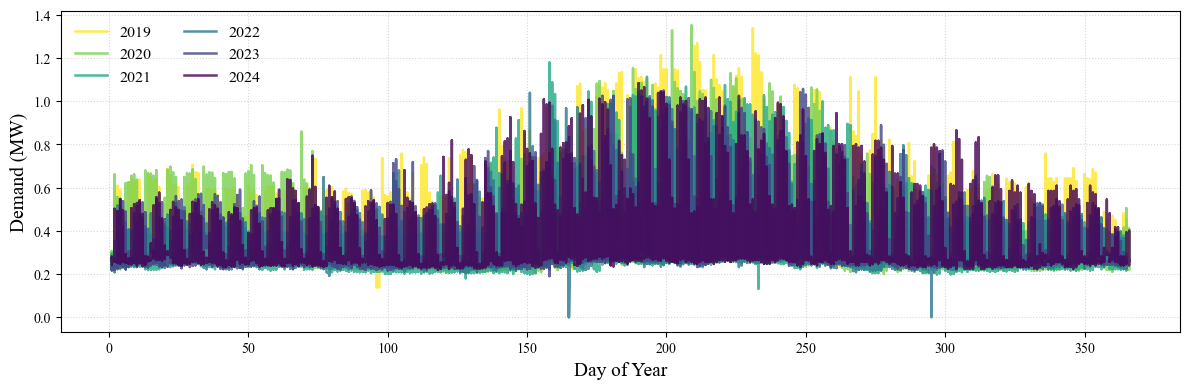

In [3]:
plt.figure(figsize=(12,4))
plt.rcParams['font.family'] = 'Times New Roman'

num_years = end_year - start_year + 1
colors = plt.cm.viridis_r(np.linspace(0, 1, num_years))

for i, year in enumerate(range(start_year, end_year + 1)):
    
    # Extract this year's data
    year_df = df[df['time'].dt.year == year].copy()
    if year_df.empty:
        continue
    
    year_df["day_of_year"] = year_df["time"].dt.dayofyear
    
    # Plot annual demand profile
    plt.plot(year_df["day_of_year"], year_df["demand_MW"], label=str(year), color=colors[i], linewidth=1.8, alpha=0.8)

# Formatting
plt.xlabel("Day of Year", fontsize=14)
plt.ylabel("Demand (MW)", fontsize=14)

plt.grid(True, linestyle=":", alpha=0.5)

plt.legend(fontsize=11.5, loc="upper left", ncol=2, bbox_to_anchor=(0, 1), frameon=False)
plt.tight_layout()

plt.show()

## Battery and Arbitrage Setup 
#### _Input parameters here_

In [4]:
# -------------------------------
# Battery ratings & parameters
# -------------------------------
P_batt = 0.6                 # Battery power rating (MW)
duration = 2.2               # Battery duration (h)
E_batt = P_batt * duration   # Energy rating (MWh)

E_min = 0.2 * E_batt         # SoC lower bound (MWh)
e0 = 0.5 * E_batt            # Initial SoC (MWh)
eta = 0.9                    # Round-trip efficiency (charge/discharge)

# -------------------------------
# Load arbitrage dispatch data
# -------------------------------
# Degradation cost = 0
dispatch_df = pd.read_csv("arbitrage_data_c0.csv", parse_dates=["Time Stamp"])

# Convert normalized charge/discharge schedule to MW
q_arb = dispatch_df["Charge_norm"].values * (E_batt / Ts)      # Charge power (MW)
d_arb = dispatch_df["Discharge_norm"].values * (E_batt / Ts)   # Discharge power (MW)

# -------------------------------
# Billing information
# -------------------------------
monthly_charge = 71  # Fixed monthly charge fom ConEd large business peak pricing structure ($)
RTP = dispatch_df["Real_Time_Price_$_per_MWh"].values  # Real-time price from NYISO ($/MWh)

## Generate Training Data via Gurobi Optimization

In [5]:
start_time = time.time()

# Storage for all years of optimization results
results_all_years = {year: {"net_demand": [], "power": [], "SoC": [], "discharge": [], "charge": [], "p_value": []}
                     for year in range(start_year, end_year + 1)}

e0_month = e0  # initial SoC for the first month of the first year

# -----------------------------------------
# Loop over each year and month in dataset
# -----------------------------------------
for year in sorted(df['time'].dt.year.unique()):
    year_df = df[df['time'].dt.year == year]
    
    for month in sorted(year_df['time'].dt.month.unique()):
        month_df = year_df[year_df['time'].dt.month == month]
        
        # Extract raw monthly demand array
        D_month = month_df['demand_MW'].values

        # Run optimization (Gurobi) for this month
        net_demand, power, SoC, discharge, charge, monthly_p = training_data_generation(E_batt, P_batt, E_min, e0_month, 
                                                                           eta, D_month, Ts, mins_in_peak, delta=1e-6)
        
        # peak demand value is constant for the month; replicate to match monthly length
        p_array = np.full_like(net_demand, monthly_p)

        # Store results
        results_all_years[year]["net_demand"].append(net_demand)
        results_all_years[year]["power"].append(power)
        results_all_years[year]["SoC"].append(SoC)
        results_all_years[year]["discharge"].append(discharge)
        results_all_years[year]["charge"].append(charge)
        results_all_years[year]["p_value"].append(p_array)

        # Update initial SoC for the next month
        e0_month = SoC[-1]

# -----------------------------------------
# Convert monthly lists into annual arrays
# -----------------------------------------
net_demand_all_years = {year: np.concatenate(results_all_years[year]["net_demand"]) for year in results_all_years}
power_all_years = {year: np.concatenate(results_all_years[year]["power"]) for year in results_all_years}
SoC_all_years = {year: np.concatenate(results_all_years[year]["SoC"]) for year in results_all_years}
discharge_all_years = {year: np.concatenate(results_all_years[year]["discharge"]) for year in results_all_years}
charge_all_years = {year: np.concatenate(results_all_years[year]["charge"]) for year in results_all_years}
P_all_years = {year: np.concatenate(results_all_years[year]["p_value"]) for year in results_all_years}

end_time = time.time()
print(f"Execution Time: {end_time - start_time:.4f} seconds")

Set parameter Username
Set parameter LicenseID to value 2676962
Academic license - for non-commercial use only - expires 2026-06-10
Execution Time: 22.3346 seconds


## Plot Training Data

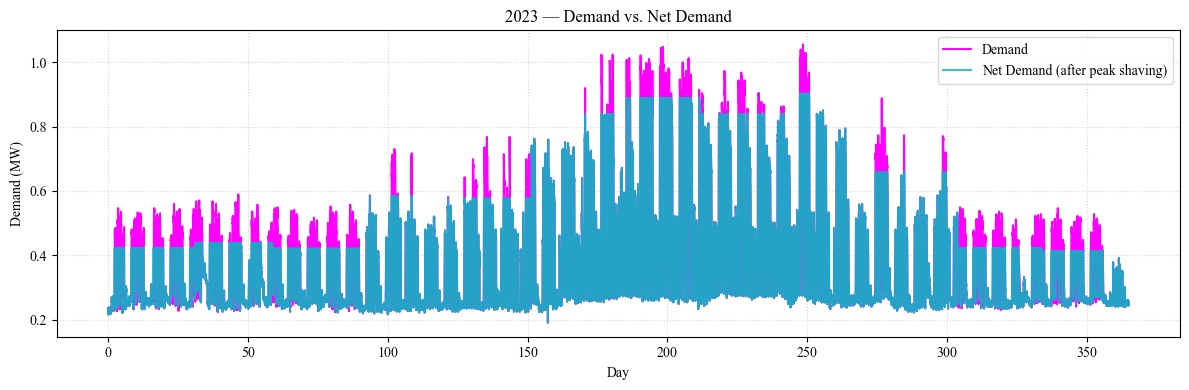

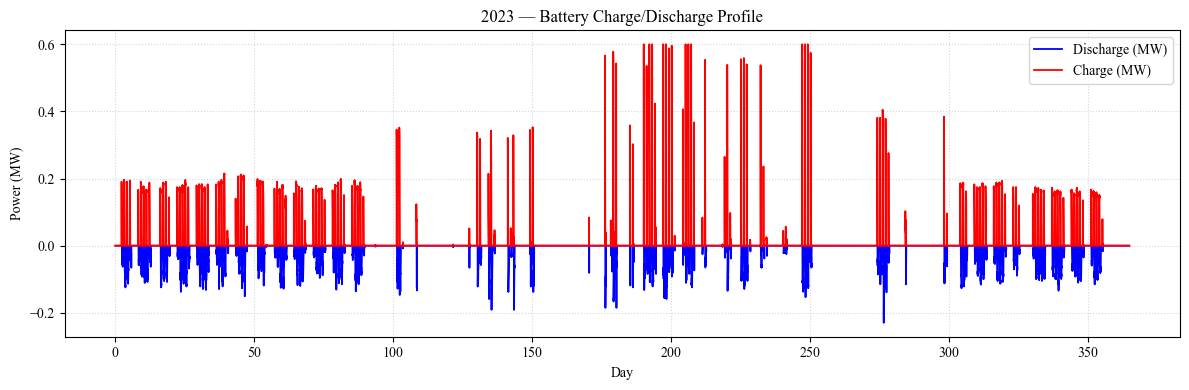

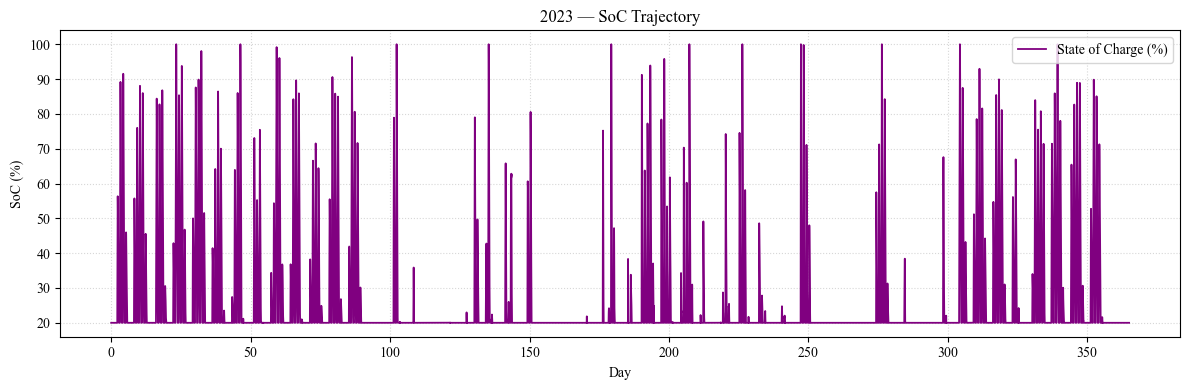

In [7]:
# -------------------------------
# Graph Settings
# -------------------------------
year_to_graph = 2023                 # Year to visualize
pts_per_day = int(24 / Ts)           # Number of data points per day

# Time range for plotting (default = full year)
idx1 = 0
idx2 = pts_per_day * 365             # Note: if leap year, adjust accordingly

# Create normalized x-axis in units of days
x_days = np.arange(idx2 - idx1) / pts_per_day


# -------------------------------
# 1. Demand vs Net Demand
# -------------------------------
plt.figure(figsize=(12, 4))

plt.plot(x_days, year_data[year_to_graph][idx1:idx2], label="Demand", color = 'magenta', linewidth=1.4)
plt.plot(x_days, net_demand_all_years[year_to_graph][idx1:idx2], label="Net Demand (after peak shaving)", color = 'c', linewidth=1.4, alpha=0.85)

plt.xlabel("Day")
plt.ylabel("Demand (MW)")
plt.title(f"{year_to_graph} — Demand vs. Net Demand")
plt.grid(True, linestyle=":", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Battery Charge / Discharge Power
# -------------------------------
plt.figure(figsize=(12, 4))

plt.plot(x_days, -discharge_all_years[year_to_graph][idx1:idx2], label="Discharge (MW)", color="blue", linewidth=1.3)
plt.plot(x_days, charge_all_years[year_to_graph][idx1:idx2], label="Charge (MW)", color="red", linewidth=1.3)

plt.xlabel("Day")
plt.ylabel("Power (MW)")
plt.title(f"{year_to_graph} — Battery Charge/Discharge Profile")
plt.grid(True, linestyle=":", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 3. SoC Trajectory
# -------------------------------
plt.figure(figsize=(12, 4))

plt.plot(x_days, (SoC_all_years[year_to_graph][idx1:idx2] / E_batt) * 100, label="State of Charge (%)", color="purple", linewidth=1.3)

plt.xlabel("Day")
plt.ylabel("SoC (%)")
plt.title(f"{year_to_graph} — SoC Trajectory")
plt.grid(True, linestyle=":", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Run Kernel Regression Controller
#### _Set regression parameters here_

In [9]:
# Set hyperparameters
# Bandwidth: sigma, look-back window: window (h), number of nearest neighbors: K, confidence interval for SoC prediction (alpha)
params = {'sigma': 0.06, 'window': 16.0, 'K': 550, 'alpha': 0.9}

summer_months = [6,7,8,9]

# Training data
all_training_demand = train_df['demand_MW'].values
training_SoC = np.concatenate([SoC_all_years[y] for y in SoC_all_years if y != year_to_predict])
training_net_demand = np.concatenate([
    pd.Series(net_demand_all_years[y], index=train_df[train_df.index.year==y].index)
      .resample('D').max()
      .reindex(train_df[train_df.index.year==y].index, method='ffill').values
    for y in net_demand_all_years if y != year_to_predict])

# Run controller
PS_net_demand, PS_q, PS_d, PS_SoC, regression_SoC, p_record, monthly_peaks = kernel_regression_controller(
    test_df=test_df, train_df=train_df, training_net_demand=training_net_demand, all_training_demand=all_training_demand,
    training_SoC=training_SoC, summer_months=summer_months, params=params, E_batt=E_batt, P_batt=P_batt, E_min=E_min,
    e0=e0, eta=eta, Ts=Ts, mins_in_peak=mins_in_peak)

# Print monthly and annual summaries
print("\n--- Peak Demand Reduction by Month ---")
for month, peaks in sorted(monthly_peaks.items()):
    reduction = peaks["original_peak_MW"] - peaks["optimized_peak_MW"]
    print(f"Month {month:02d}: Original = {peaks['original_peak_MW']:.6f} MW, "
          f"Optimized = {peaks['optimized_peak_MW']:.6f} MW, "
          f"Reduction = {reduction:.6f} MW")

total_original = sum(v["original_peak_MW"] for v in monthly_peaks.values())
total_optimized = sum(v["optimized_peak_MW"] for v in monthly_peaks.values())
total_reduction = total_original - total_optimized

print("\n=== Annual Summary ===")
print(f"Sum of Original Peaks:   {total_original:.6f} MW")
print(f"Sum of Optimized Peaks:  {total_optimized:.6f} MW")
print(f"Total Reduction:       {total_reduction:.6f} MW")
print("="*40)

→ Starting new month: 2024-01
→ Starting new month: 2024-02
→ Starting new month: 2024-03
→ Starting new month: 2024-04
→ Starting new month: 2024-05
→ Starting new month: 2024-06
→ Starting new month: 2024-07
→ Starting new month: 2024-08
→ Starting new month: 2024-09
→ Starting new month: 2024-10
→ Starting new month: 2024-11
→ Starting new month: 2024-12

--- Peak Demand Reduction by Month ---
Month 01: Original = 0.576000 MW, Optimized = 0.530750 MW, Reduction = 0.045250 MW
Month 02: Original = 0.545630 MW, Optimized = 0.489039 MW, Reduction = 0.056591 MW
Month 03: Original = 0.739556 MW, Optimized = 0.605387 MW, Reduction = 0.134169 MW
Month 04: Original = 0.735259 MW, Optimized = 0.647043 MW, Reduction = 0.088217 MW
Month 05: Original = 0.920444 MW, Optimized = 0.761709 MW, Reduction = 0.158736 MW
Month 06: Original = 0.999556 MW, Optimized = 0.964951 MW, Reduction = 0.034604 MW
Month 07: Original = 1.081333 MW, Optimized = 0.963471 MW, Reduction = 0.117862 MW
Month 08: Original 

## Plot Kernel Regression Controller Results

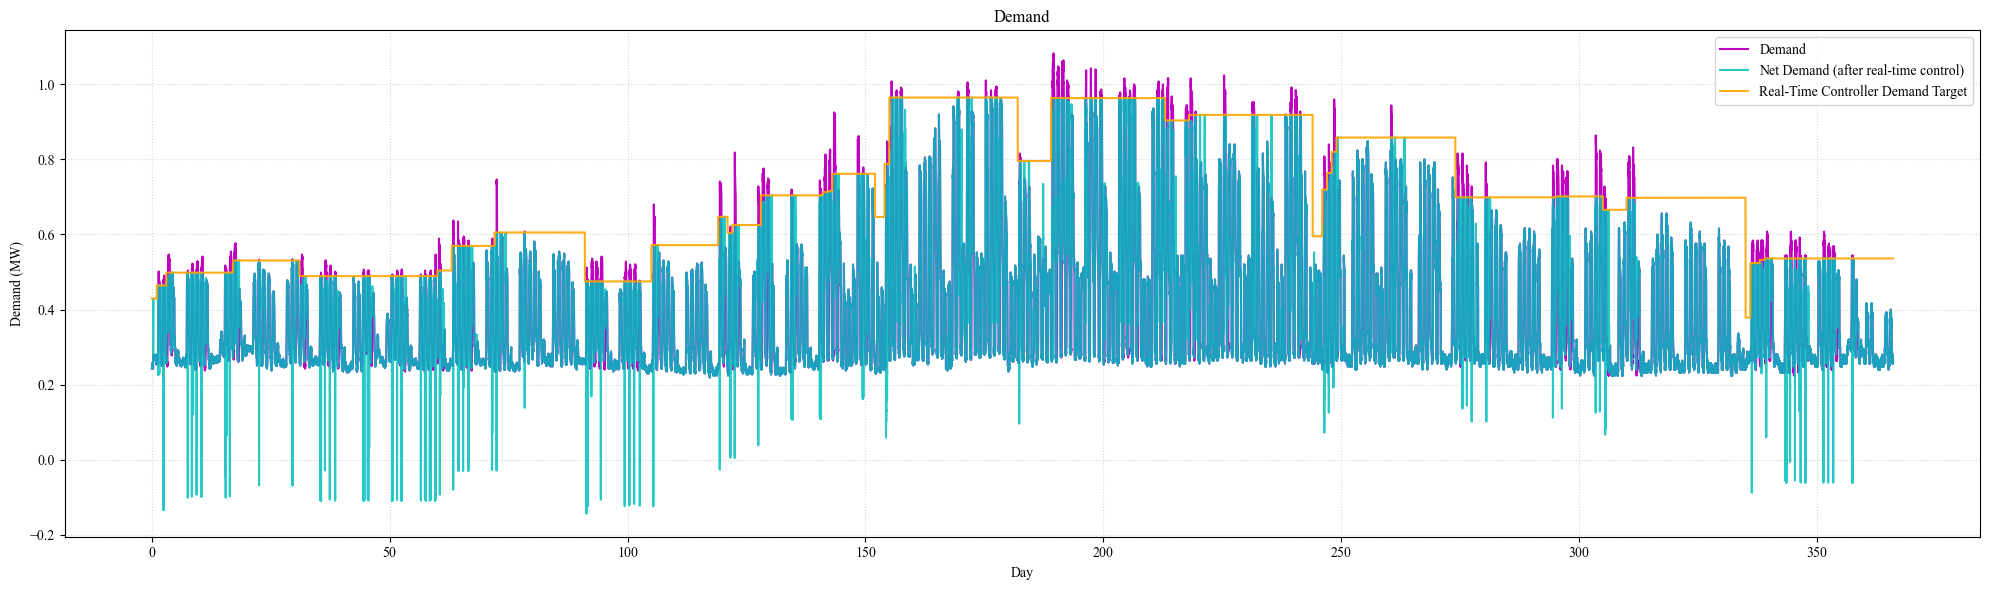

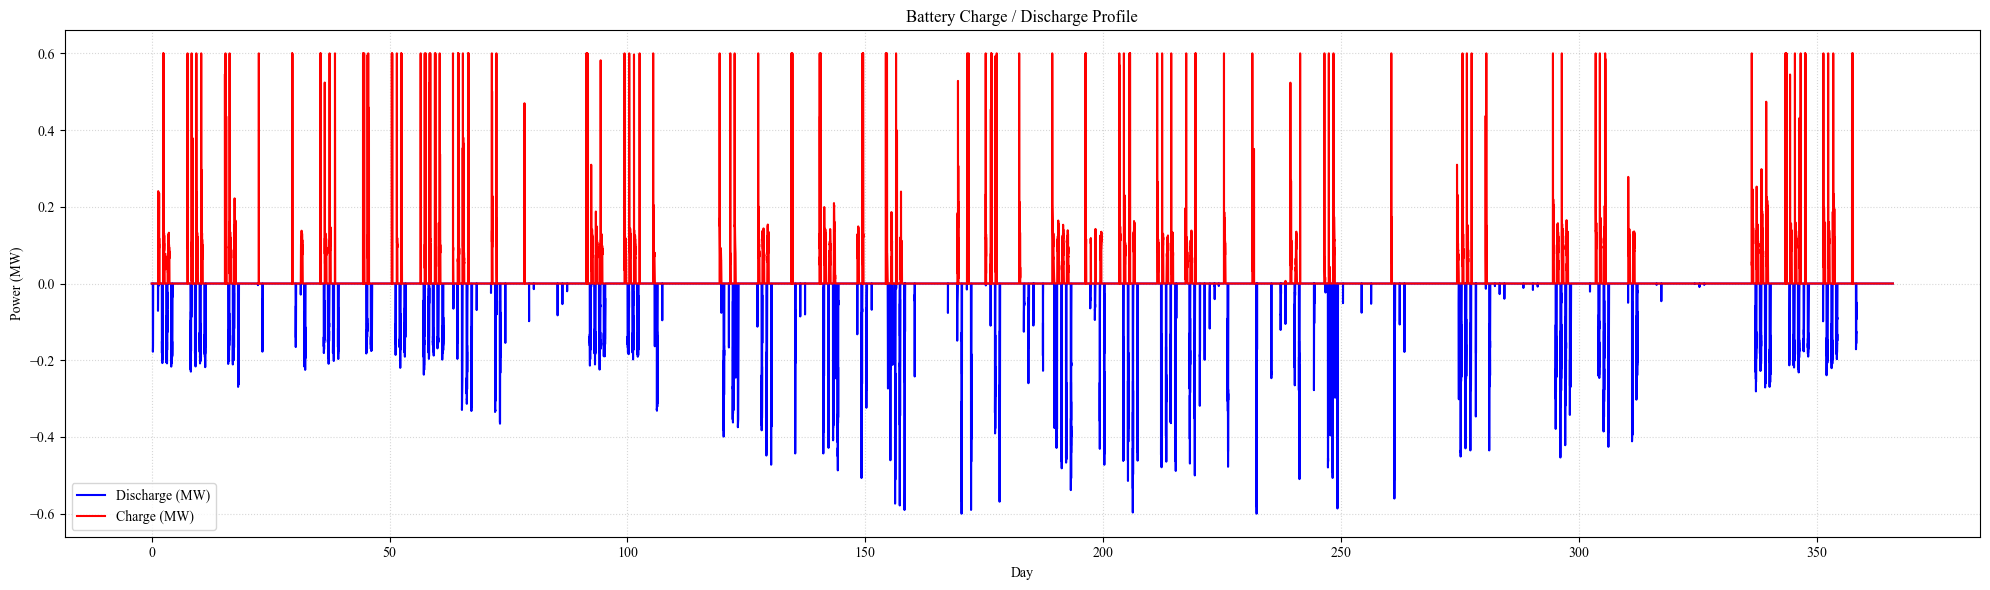

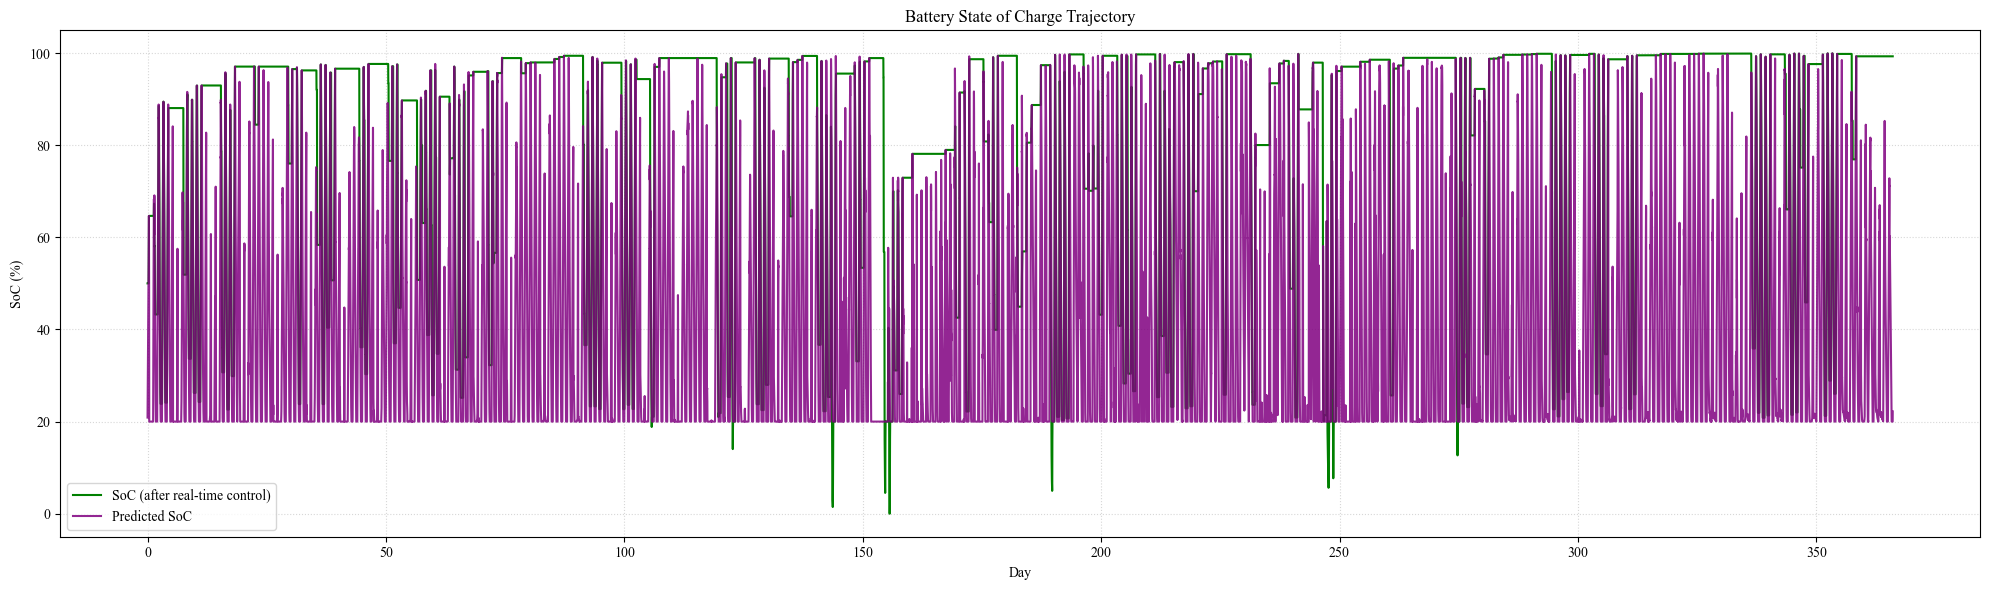

In [18]:
# Define time range for plotting (days)
idx1 = 0
idx2 = int(24 / Ts) * 366 
x_days = np.arange(idx2 - idx1) / (24 / Ts)

# -------------------------------
# 1. Demand vs Controller / Kernel Predictions
# -------------------------------

plt.figure(figsize=(20, 6))
plt.clf()

# Plot original demand
plt.plot(x_days, test_df['demand_MW'].values[idx1:idx2], label='Demand', color='m', linewidth=1.5)

# Plot net demand after real-time control
plt.plot(x_days, PS_net_demand[idx1:idx2], label='Net Demand (after real-time control)', color='c', alpha=0.85, linewidth=1.5)

# Plot real-time controller peak shaving target
plt.plot(x_days, p_record[idx1:idx2], label='Real-Time Controller Demand Target', color='orange', alpha=0.9, linewidth=1.5)

# Plot kernel regression predicted net demand
#plt.plot(x_days, timestep_B[idx1:idx2], label='Predicted Net Demand', color='purple', alpha=0.9, linewidth=1.5)

# Labels, grid, legend, title
plt.xlabel('Day')
plt.ylabel('Demand (MW)')
plt.title('Demand')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Battery Charge / Discharge Power
# -------------------------------

plt.figure(figsize=(20, 6))
plt.clf()

# Plot discharge and charge
plt.plot(x_days, -PS_q[idx1:idx2], label='Discharge (MW)', color='blue', linewidth=1.5)
plt.plot(x_days, PS_d[idx1:idx2], label='Charge (MW)', color='red', linewidth=1.5)

plt.xlabel('Day')
plt.ylabel('Power (MW)')
plt.title('Battery Charge / Discharge Profile')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 3. SoC Trajectory
# -------------------------------
plt.figure(figsize=(20, 6))
plt.clf()

# Plot Real-Time Controller SoC
plt.plot(x_days, (PS_SoC[idx1:idx2] / E_batt) * 100, label='SoC (after real-time control)', color='green', linewidth=1.5)

# Plot Kernel Regression SoC
plt.plot(x_days, (regression_SoC[idx1:idx2] / E_batt) * 100, label='Predicted SoC', color='purple', linewidth=1.5, alpha=0.85)

plt.xlabel('Day')
plt.ylabel('SoC (%)')
plt.title('Battery State of Charge Trajectory')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Add Arbitrage

In [11]:
PSA_SoC, PSA_net_demand, PSA_q, PSA_d = add_arbitrage(test_df['demand_MW'].values, PS_q, PS_d, PS_SoC,
                                                            P_batt, E_batt, Ts, p_record, eta, q_arb, d_arb, e0)

## Plot Peak Shaving and Arbitrage Combined Results

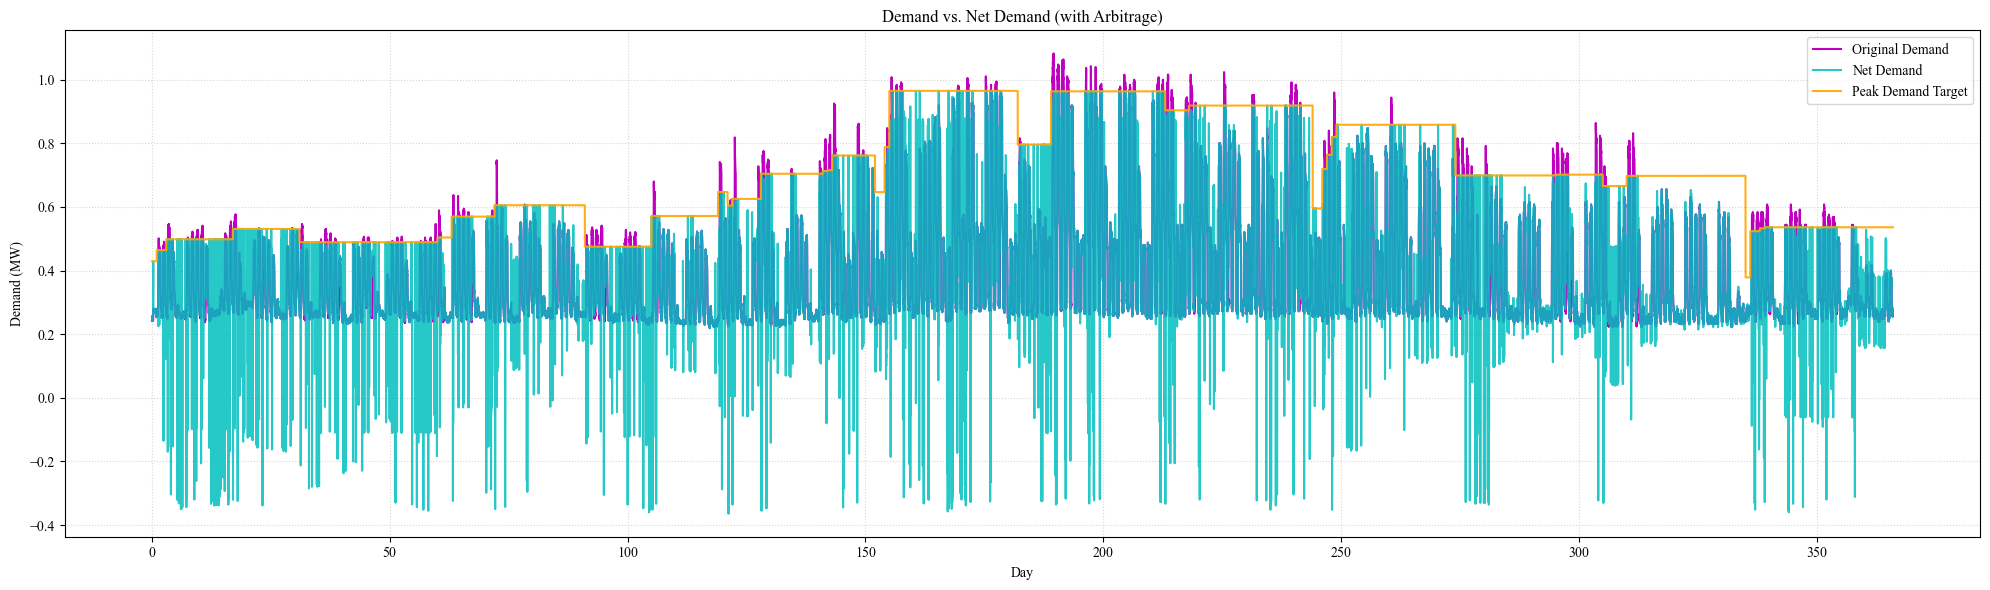

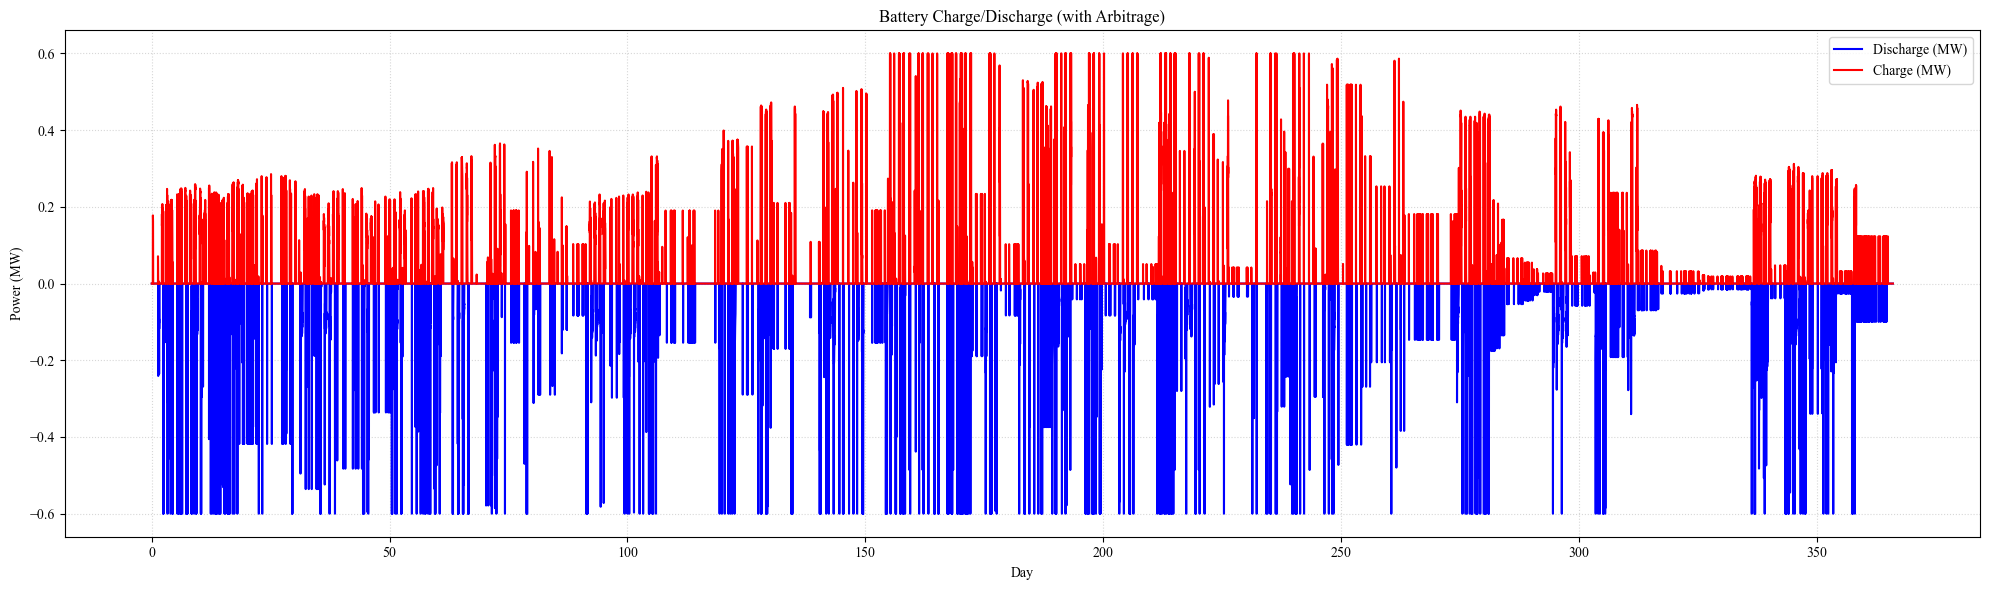

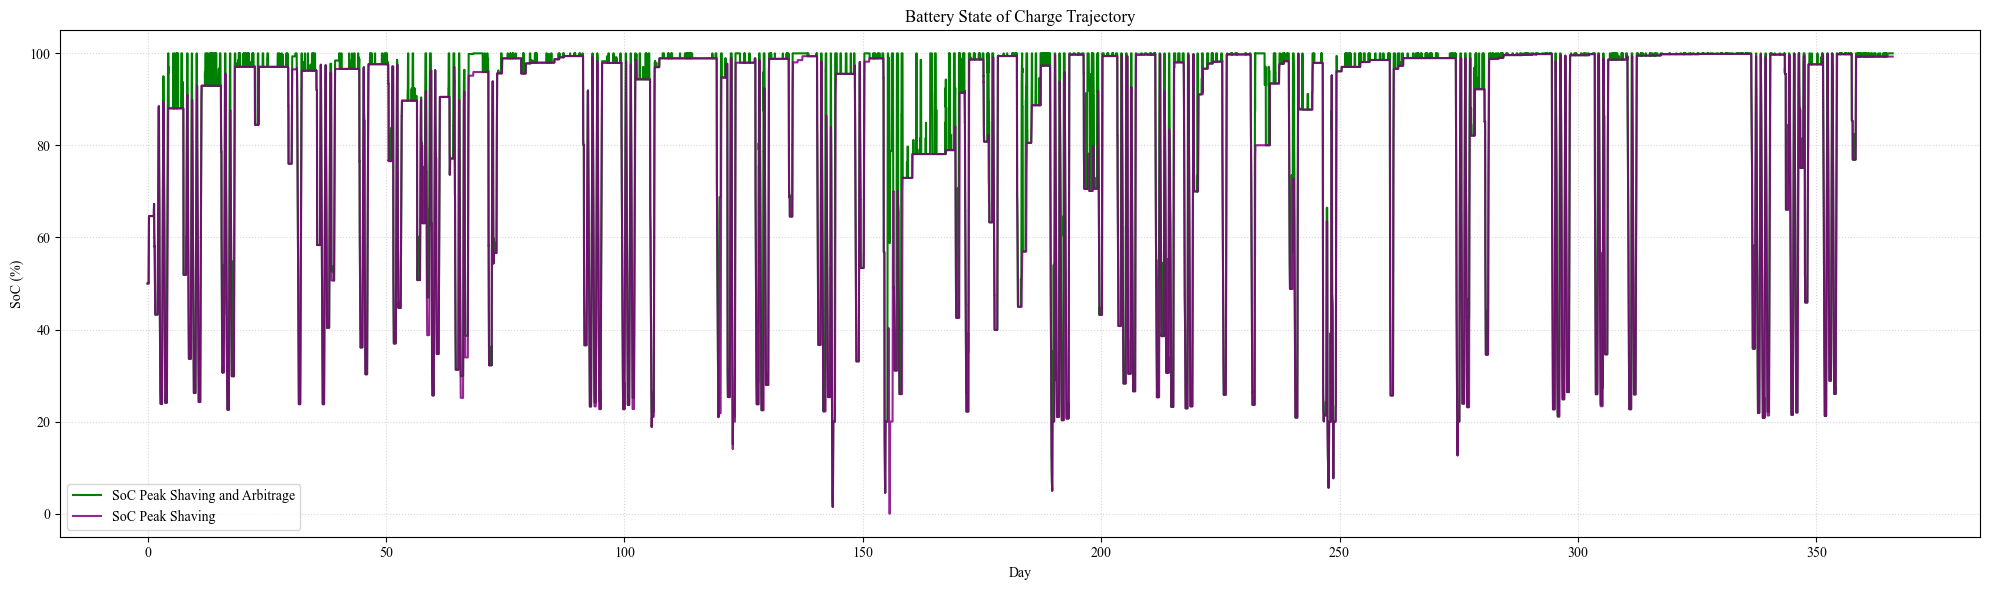

In [12]:
# -------------------------------
# Time Setup
# -------------------------------
idx1 = 0
idx2 = int(24 / Ts) * 366
x_days = np.arange(len(test_df['demand_MW'].values[idx1:idx2])) / (24 / Ts) 

# -------------------------------
# 1. Demand vs Net Demand
# -------------------------------
plt.figure(figsize=(20, 6))
plt.clf()

plt.plot(x_days, test_df['demand_MW'].values[idx1:idx2], label='Original Demand', color='m')
plt.plot(x_days, PSA_net_demand[idx1:idx2], label='Net Demand', color='c', alpha=0.85)
plt.plot(x_days, p_record[idx1:idx2], label='Peak Demand Target', color='orange', alpha=0.9)

plt.xlabel('Day')
plt.ylabel('Demand (MW)')
plt.title('Demand vs. Net Demand (with Arbitrage)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# -------------------------------
# 2. Battery Charge/Discharge Power
# -------------------------------
plt.figure(figsize=(20, 6))
plt.clf()

plt.plot(x_days, -PSA_d[idx1:idx2], label='Discharge (MW)', color='blue', linewidth=1.5)
plt.plot(x_days, PSA_q[idx1:idx2], label='Charge (MW)', color='red', linewidth=1.5)

plt.xlabel('Day')
plt.ylabel('Power (MW)')
plt.title('Battery Charge/Discharge (with Arbitrage)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# -------------------------------
# 3. SoC Trajectory
# -------------------------------
plt.figure(figsize=(20, 6))
plt.clf()

plt.plot(x_days, (PSA_SoC[idx1:idx2] / E_batt) * 100, label='SoC Peak Shaving and Arbitrage', color='green', linewidth=1.5)
plt.plot(x_days, (PS_SoC[idx1:idx2] / E_batt) * 100, label='SoC Peak Shaving', color='purple', linewidth=1.5, alpha=0.85)

plt.xlabel('Day')
plt.ylabel('SoC (%)')
plt.title('Battery State of Charge Trajectory')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Cycle Count

In [13]:
print(f'Cycle Number for Peak Shaving and Arbitrage: {sum(PSA_d)/eta*Ts/E_batt:.2f}')
print(f'Cycle Number for Peak Shaving Only: {sum(PS_d)/eta*Ts/E_batt:.2f}')
print(f'Cycle Number for Arbitrage Schedule (Before Integration with Peak Shaving): {sum(d_arb)/eta*Ts/E_batt:.2f}')

Cycle Number for Peak Shaving and Arbitrage: 98.87
Cycle Number for Peak Shaving Only: 71.30
Cycle Number for Arbitrage Schedule (Before Integration with Peak Shaving): 293.37


## Bill Calculation

In [14]:
# -------------------------------
# Bill Calculation
# -------------------------------

# 1. Calculate the bill without storage
print("No Storage")
bill_no_storage = calculate_total_bill(demand_profile=test_df['demand_MW'].values, timestamps=test_df.index, Ts=Ts, mins_in_peak=mins_in_peak,
    monthly_charge=monthly_charge, RTP=RTP, std_pricing=True, verbose=True)

# 2. Calculate the bill with peak shaving + arbitrage
print("Peak Shaving and Arbitrage")
bill_PSA = calculate_total_bill(demand_profile=PSA_net_demand, timestamps=test_df.index, Ts=Ts, mins_in_peak=mins_in_peak,
    monthly_charge=monthly_charge, RTP=RTP, std_pricing=True, verbose=True)

# 3. Calculate the bill with just peak shaving
print("Peak Shaving Only")
bill_PS = calculate_total_bill(demand_profile=PS_net_demand, timestamps=test_df.index, Ts=Ts, mins_in_peak=mins_in_peak,
    monthly_charge=monthly_charge, RTP=RTP, std_pricing=True, verbose=True)

# 4. Compute savings
savings_PSA = bill_no_storage - bill_PSA
savings_PS = bill_no_storage - bill_PS

# 5. Print results
print("\n--- Bill Comparison ---")
print(f"Total Bill (without Storage): ${bill_no_storage:,.2f}")
print(f"Total Bill (Peak Shaving and Arbitrage):  ${bill_PSA:,.2f}")
print(f"Total Bill (Peak Shaving Only):         ${bill_PS:,.2f}")
print("-" * 30)
print(f"Total Savings (with Peak Shaving and Arbitrage): ${savings_PSA:,.2f}")
print(f"Total Savings (with Peak Shaving Only): ${savings_PS:,.2f}")

No Storage
--- Peak Demand Price Breakdown ---
Month 01 | all_hours    | Peak 0.5760 MW @ 2024-01-18 15:10 | Rate $33.50/kW | Cost $19,296.00
Month 02 | all_hours    | Peak 0.5456 MW @ 2024-02-01 13:20 | Rate $33.50/kW | Cost $18,278.59
Month 03 | all_hours    | Peak 0.7396 MW @ 2024-03-13 12:15 | Rate $33.50/kW | Cost $24,775.11
Month 04 | all_hours    | Peak 0.7353 MW @ 2024-04-29 15:20 | Rate $33.50/kW | Cost $24,631.19
Month 05 | all_hours    | Peak 0.9204 MW @ 2024-05-23 10:00 | Rate $33.50/kW | Cost $30,834.89
Month 06 | all_hours    | Peak 0.9996 MW @ 2024-06-20 11:15 | Rate $42.80/kW | Cost $42,780.98
Month 07 | all_hours    | Peak 1.0813 MW @ 2024-07-08 12:55 | Rate $42.80/kW | Cost $46,281.07
Month 08 | all_hours    | Peak 1.0120 MW @ 2024-08-01 14:10 | Rate $42.80/kW | Cost $43,313.60
Month 09 | all_hours    | Peak 0.9493 MW @ 2024-09-05 13:10 | Rate $42.80/kW | Cost $40,631.47
Month 10 | all_hours    | Peak 0.8533 MW @ 2024-10-30 12:50 | Rate $33.50/kW | Cost $28,586.67
Mon

## Automatic Parameter Search

In [ ]:
# Baseline parameters
base_params = {'window': 12, 'sigma': 0.05, 'K': 550, 'alpha': 0.9}

# Refinement step sizes
WINDOW_STEP = 0.5      # hours
SIGMA_STEP = 0.05      # logarithmic
K_STEP = 50            # number of neighbors

# Parameter bounds
WINDOW_MIN, WINDOW_MAX = 1.0, 48.0       
SIGMA_MIN, SIGMA_MAX = 0.001, 10.0       
K_MIN, K_MAX = 10, 5000                  

# Coarse candidate grids
window_candidates = [6, 12, 16, 18, 22, 24]
sigma_candidates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]
K_candidates = [50, 150, 300, 500, 700, 1000, 1500]

conv_thresh = 50   # Stop refinement when marginal improvement is < $50

# ----------------------------------
# Run hierarchical parameter search
# ----------------------------------
best_result, all_results_df = hierarchical_search(
    # Input data
    test_df=test_df, train_df=train_df, training_net_demand=training_net_demand, 
    all_training_demand=all_training_demand, training_SoC=training_SoC, summer_months=[6,7,8,9],
    
    # Battery Specs
    E_batt=E_batt, P_batt=P_batt, E_min=E_min, e0=e0, eta=eta, Ts=Ts, q_arb = q_arb, d_arb = d_arb, mins_in_peak=mins_in_peak,
    
    # Search Configuration
    base_params=base_params, window_candidates=window_candidates, sigma_candidates=sigma_candidates, K_candidates=K_candidates,
    WINDOW_MIN=WINDOW_MIN, WINDOW_MAX=WINDOW_MAX, SIGMA_MIN=SIGMA_MIN, SIGMA_MAX=SIGMA_MAX, K_MIN=K_MIN, K_MAX=K_MAX,
    window_step=WINDOW_STEP, sigma_step=SIGMA_STEP, K_step=K_STEP, conv_thresh=conv_thresh,
    
    # Pricing data
    monthly_charge=monthly_charge, RTP=RTP,                       
    
    # Misc
    autosave_path=f'hierarchical_results_{P_batt}MW.csv')

# ----------------------------------
# Show best result
# ----------------------------------
print("\n*** Best Parameters ***")
print(best_result['params'])
print(f"Savings: ${best_result['savings_usd']:.2f}")

_____________________________________________________________________________________________________________________________

## Deterministic Formulation

In [15]:
# Month Mapping
MONTH_MAP = {1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10:'oct', 11:'nov', 12:'dec'}

# Containers for monthly data
demand_data = {}

# ---------------------------------------------------------------
# Organize monthly demand into a dictionary
# ---------------------------------------------------------------
for (y, m), grp in df.groupby([df['time'].dt.year, df['time'].dt.month]):
    month_abbr = MONTH_MAP[m]
    key = f"demand_{y}_{month_abbr}"
    demand_data[key] = grp['demand_MW'].values


# ---------------------------------------------------------------
# Build full-year demand and price arrays
# ---------------------------------------------------------------
D_full_list = []
prices_full_list = []
monthly_peak_prices = []    # peak price per month
month_timesteps = []        # number of steps per month
start_idx = 0

for m in range(1, 13):
    month_abbr = MONTH_MAP[m]
    key = f"demand_{year_to_predict}_{month_abbr}"
    # Select peak demand price
    # Summer months use higher peak pricing (ConEd large business standard pricing)
    if 6 <= m <= 9:
        peak_price = 42.80 * 1000
    else:
        peak_price = 33.50 * 1000

    monthly_peak_prices.append(peak_price)

    # Validate data availability
    if key not in demand_data:
        print(f"Missing demand data for {year_to_predict}-{month_abbr}. Aborting full-year run.")
        break

    D_month = demand_data[key]

    # Slice matching prices
    end_idx = start_idx + len(D_month)
    if end_idx > len(RTP):
        raise ValueError(f"RTP price array too short for month {month_abbr}. " f"Needed {end_idx}, length={len(RTP)}")

    prices_month = RTP[start_idx:end_idx]

    # Append results
    D_full_list.append(D_month)
    prices_full_list.append(prices_month)
    month_timesteps.append(len(D_month))

    start_idx = end_idx  # move index forward

# Final concatenation
D_full = np.concatenate(D_full_list)
prices_full = np.concatenate(prices_full_list)

# ---------------------------------------------------------------
# Run Optimization - Peak shaving and arbitrage
# ---------------------------------------------------------------

print('Starting optimization for peak shaving and arbitrage...')

PSA_results = deterministic_controller(E_batt=E_batt, P_batt=P_batt, E_min=E_min, e0=e0, eta=eta, D_full=D_full,
    prices_full=prices_full, Ts=Ts, c=0, delta=1e-6, monthly_peak_prices=monthly_peak_prices, 
    month_timesteps=month_timesteps, max_annual_cycles=366, arb=True)

(net_d_PS_Arb_opt_full, PSA_SoC_full, d_opt_PSA_full, q_opt_PSA_full, p_values_PSA) = PSA_results

# ---------------------------------------------------------------
# Run Optimization - Peak shaving only
# ---------------------------------------------------------------
print('Starting optimization for peak shaving only...')

PS_results = deterministic_controller(E_batt=E_batt, P_batt=P_batt, E_min=E_min, e0=e0, eta=eta, D_full=D_full,
    prices_full=prices_full, Ts=Ts, c=0, delta=1e-6, monthly_peak_prices=monthly_peak_prices, 
    month_timesteps=month_timesteps, max_annual_cycles=None, arb=False)

(net_d_PS_opt_full, SoC_PS_full, d_opt_PS_full, q_opt_PS_full, p_values_PS) = PS_results

# ---------------------------------------------------------------
# Print Monthly Peaks
# ---------------------------------------------------------------
print(f"PS + Arbitrage monthly peaks:\n{p_values_PSA}")
print(f"PS only monthly peaks:\n{p_values_PS}")

Starting optimization for peak shaving and arbitrage...
Optimization complete. Total cycles: 366.00
Starting optimization for peak shaving only...
Optimization complete. Total cycles: 80.66
PS + Arbitrage monthly peaks:
[0.4367453  0.42242667 0.47124258 0.60405535 0.74784299 0.8776022
 0.93396129 0.87097011 0.74264828 0.67031795 0.66254815 0.47271724]
PS only monthly peaks:
[0.4367453  0.42242667 0.47124258 0.60405535 0.74784299 0.8776022
 0.93396129 0.87097011 0.74264828 0.67031795 0.66254815 0.47271724]


## Bill Calculation

In [16]:
print('Peak Shaving and Arbitrage')
# Calculate the bill with the combined strategy
opt_bill_PSA = calculate_total_bill(demand_profile=net_d_PS_Arb_opt_full, timestamps=test_df.index, Ts=Ts, 
                                         mins_in_peak=mins_in_peak, monthly_charge=monthly_charge, RTP=RTP, std_pricing = True, verbose=True)
print(f'Savings: ${bill_no_storage-opt_bill_PSA:.2f}')

print('\nPeak Shaving Only')
opt_bill_PS = calculate_total_bill(demand_profile=net_d_PS_opt_full, timestamps=test_df.index, Ts=Ts, 
                                         mins_in_peak=mins_in_peak, monthly_charge=monthly_charge, RTP=RTP, std_pricing=True, verbose=True)
print(f'Savings: ${bill_no_storage-opt_bill_PS:.2f}')

Peak Shaving and Arbitrage
--- Peak Demand Price Breakdown ---
Month 01 | all_hours    | Peak 0.4367 MW @ 2024-01-01 04:25 | Rate $33.50/kW | Cost $14,630.97
Month 02 | all_hours    | Peak 0.4224 MW @ 2024-02-01 00:00 | Rate $33.50/kW | Cost $14,151.29
Month 03 | all_hours    | Peak 0.4712 MW @ 2024-03-01 00:00 | Rate $33.50/kW | Cost $15,786.63
Month 04 | all_hours    | Peak 0.6041 MW @ 2024-04-01 12:50 | Rate $33.50/kW | Cost $20,235.85
Month 05 | all_hours    | Peak 0.7478 MW @ 2024-05-01 02:40 | Rate $33.50/kW | Cost $25,052.74
Month 06 | all_hours    | Peak 0.8776 MW @ 2024-06-13 04:05 | Rate $42.80/kW | Cost $37,561.37
Month 07 | all_hours    | Peak 0.9340 MW @ 2024-07-02 07:55 | Rate $42.80/kW | Cost $39,973.54
Month 08 | all_hours    | Peak 0.8710 MW @ 2024-08-01 07:25 | Rate $42.80/kW | Cost $37,277.52
Month 09 | all_hours    | Peak 0.7426 MW @ 2024-09-01 04:35 | Rate $42.80/kW | Cost $31,785.35
Month 10 | all_hours    | Peak 0.6703 MW @ 2024-10-01 02:55 | Rate $33.50/kW | Cos

## Plot Deterministic Combined Peak Shaving and Arbitrage Results

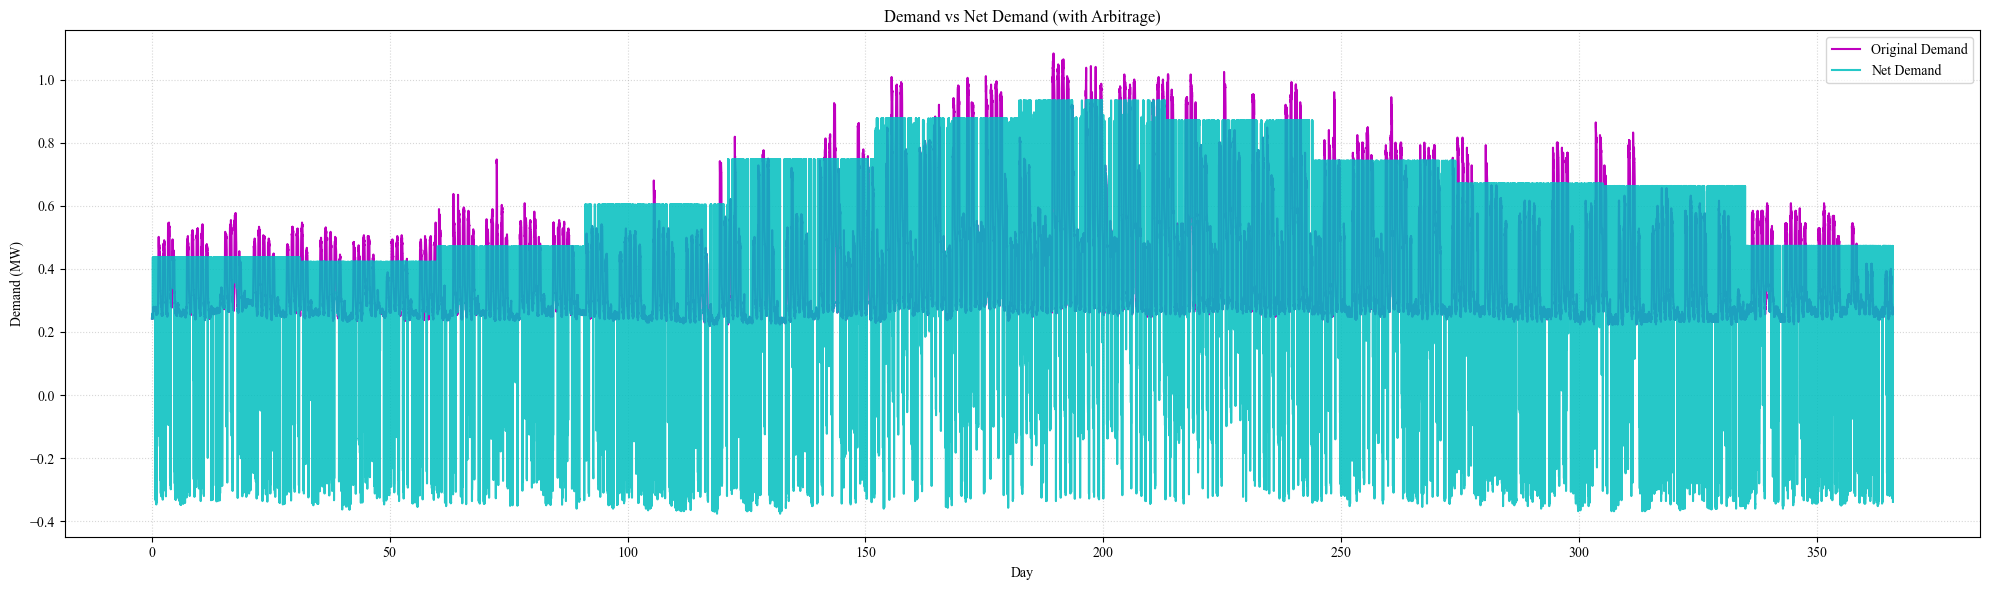

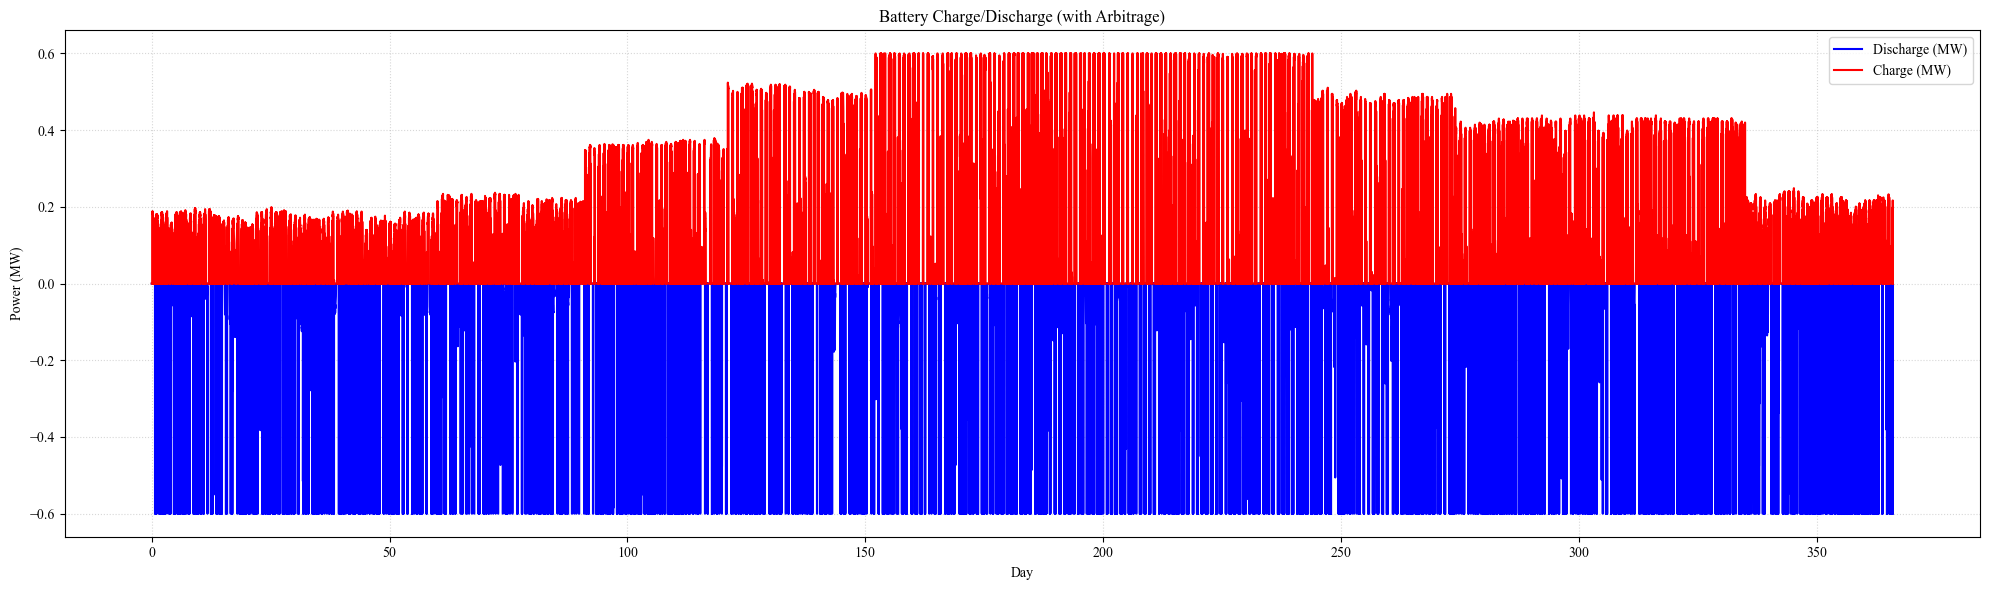

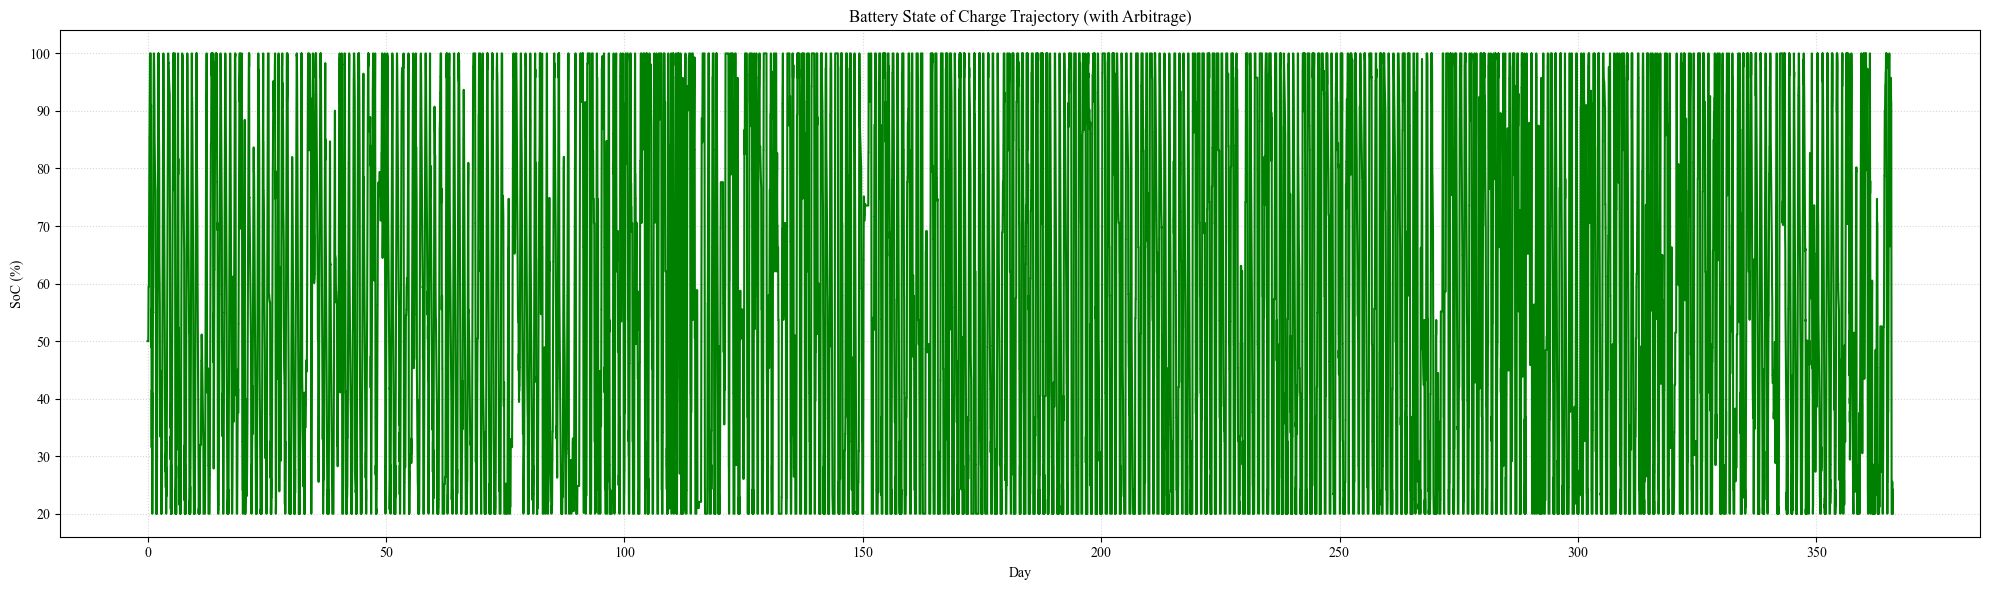

In [17]:
# -------------------------------
# Time Setup
# -------------------------------
idx1 = 0
idx2 = int(24 / Ts) * 366
x_days = np.arange(len(test_df['demand_MW'].values[idx1:idx2])) / (24 / Ts) 

# -------------------------------
# 1. Demand vs Net Demand
# -------------------------------
plt.figure(figsize=(20, 6))
plt.clf()

plt.plot(x_days, test_df['demand_MW'].values[idx1:idx2], label='Original Demand', color='m')
plt.plot(x_days, net_d_PS_Arb_opt_full[idx1:idx2], label='Net Demand', color='c', alpha=0.85)

plt.xlabel('Day')
plt.ylabel('Demand (MW)')
plt.title('Demand vs Net Demand (with Arbitrage)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# -------------------------------
# 2. Battery Charge/Discharge Power
# -------------------------------
plt.figure(figsize=(20, 6))
plt.clf()

plt.plot(x_days, -d_opt_PSA_full[idx1:idx2], label='Discharge (MW)', color='blue', linewidth=1.5)
plt.plot(x_days, q_opt_PSA_full[idx1:idx2], label='Charge (MW)', color='red', linewidth=1.5)

plt.xlabel('Day')
plt.ylabel('Power (MW)')
plt.title('Battery Charge/Discharge (with Arbitrage)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# -------------------------------
# 3. SoC Trajectory
# -------------------------------
plt.figure(figsize=(20, 6))
plt.clf()

plt.plot(x_days, (PSA_SoC_full[idx1:idx2] / E_batt) * 100, label='SoC Peak Shaving and Arbitrage', color='green', linewidth=1.5)

plt.xlabel('Day')
plt.ylabel('SoC (%)')
plt.title('Battery State of Charge Trajectory (with Arbitrage)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()